In [1]:
%load_ext autoreload
%autoreload 2

from functools import partial
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import seaborn as sns
import sys
import torch
from torch import Tensor
from typing import *

from sparq_benchmark import benchmark_call, gather
import gather_matmul as G

sns.set_context("notebook")

# Run benchmark

In [2]:
def reference_gather_inner_bmv(a: Tensor, b: Tensor, i: Tensor) -> Tensor:
    return gather(a, 2, i[:, None, :]) @ gather(b, 1, i[:, :, None])

def reference_slice_inner_bmv(a: Tensor, b: Tensor, i: Tensor) -> Tensor:
    return a[:, :, : i.shape[1]] @ b[:, : i.shape[1], :]

def run_benchmark(g: int, k_pre: int, k: int, n: int, dtype: str,
                  method: str, transpose_B: bool, chunk: Optional[int]) -> Dict[str, Any]:
    device, dtype_ = torch.device("cuda"), getattr(torch, dtype)
    config = dict(
        g=g, k_pre=k_pre, k=k, n=n, dtype=dtype,
        method=method, transpose_B=transpose_B, chunk=chunk,
    )
    try:
        A = torch.randn(g, 1, k_pre, device=device, dtype=dtype_)
        B = torch.randn(g, k_pre, n, device=device, dtype=dtype_)
        if transpose_B:
            B = B.transpose(-1, -2).contiguous().transpose(-1, -2)
        I = torch.randint(0, k_pre, (g, k), device=device)
        method_fn = dict(
            torch=partial(reference_gather_inner_bmv, A, B, I),
            slice=partial(reference_slice_inner_bmv, A, B, I),
            custom=partial(G.gather_inner_bmv, A, B, I, chunk=chunk),
        )[method]
        times = benchmark_call(
            method_fn, reps=100, warmup=10, device=device, pre_fn=lambda: torch.randint(0, k_pre, I.shape, out=I)
        )
        return dict(
            **config, time=float(times.mean()), time_stderr=float(times.std() / len(times)**.5),
            device=torch.cuda.get_device_name(),
        )
    except Exception as error:
        print(f"Failed config {config} {error}", file=sys.stderr)

In [4]:
torch.seed()

# Sweep around SparQ's approximate QK matmul
df = pd.DataFrame.from_dict(filter(None, [
    run_benchmark(g=g, k_pre=128, k=k, n=n, dtype="float16",
                  method=method, transpose_B=False, chunk=chunk)
    for g in [256, 1024, 4096]
    for k in [16, 32, 64]
    for n in [1024, 4096, 16384]
    for method in ["torch", "slice", "custom"]
    for chunk in (map(int, 2**torch.arange(0, 13)) if method == "custom" else [None])
    if not (g >= 2048 and n >= 16384)  # unrecoverable error
]))

def bytes_transferred(s: pd.Series) -> float:
    bytes_per_param = dict(float16=2, float32=4)[s["dtype"]]
    return s.g * (2 * s.k + s.k * s.n + s.n) * bytes_per_param

df["bytes_transferred"] = df.apply(bytes_transferred, axis=1)
df["effective_bandwidth"] = df.bytes_transferred / df.time
df.to_json("../out/gather_matmul_benchmark/gather_inner_bmv.json")

Failed config {'g': 256, 'k_pre': 128, 'k': 64, 'n': 1024, 'dtype': 'float16', 'method': 'custom', 'transpose_B': False, 'chunk': 4096} 'Slice' object has no attribute 'lineno'
Failed config {'g': 256, 'k_pre': 128, 'k': 64, 'n': 4096, 'dtype': 'float16', 'method': 'custom', 'transpose_B': False, 'chunk': 4096} 'Slice' object has no attribute 'lineno'
Failed config {'g': 256, 'k_pre': 128, 'k': 64, 'n': 16384, 'dtype': 'float16', 'method': 'custom', 'transpose_B': False, 'chunk': 4096} 'Slice' object has no attribute 'lineno'
Failed config {'g': 1024, 'k_pre': 128, 'k': 64, 'n': 1024, 'dtype': 'float16', 'method': 'custom', 'transpose_B': False, 'chunk': 4096} 'Slice' object has no attribute 'lineno'
Failed config {'g': 1024, 'k_pre': 128, 'k': 64, 'n': 4096, 'dtype': 'float16', 'method': 'custom', 'transpose_B': False, 'chunk': 4096} 'Slice' object has no attribute 'lineno'
Failed config {'g': 1024, 'k_pre': 128, 'k': 64, 'n': 16384, 'dtype': 'float16', 'method': 'custom', 'transpose_

# 1. A good default `chunk=512`

In [5]:
device_name, = df.device.unique()
expected_memory_bandwidth = {  # B/s
    "NVIDIA A10G": 600e9,
}[device_name]
best = (
    df.pipe(lambda d: d[d.method == "custom"])
    .groupby(["g", "k", "n"])
        .apply(lambda s: s.iloc[s.effective_bandwidth.argmax()][["bytes_transferred", "chunk", "effective_bandwidth"]])
        .reset_index()
)

print("Best chunk size:")
display(best.pivot_table(index=["g"], columns=["k", "n"], values="chunk")
        .style.format(lambda x: "" if pd.isna(x) else f"{x:.0f}"))

print("Achieved bandwidth:")
display(best.pivot_table(index=["g"], columns=["k", "n"], values="effective_bandwidth")
        .style
        .format(lambda x: "" if pd.isna(x) else f"{x/1e9:.0f}")
        .background_gradient("flare_r", vmin=0, vmax=expected_memory_bandwidth))

Best chunk size:


Achieved bandwidth:


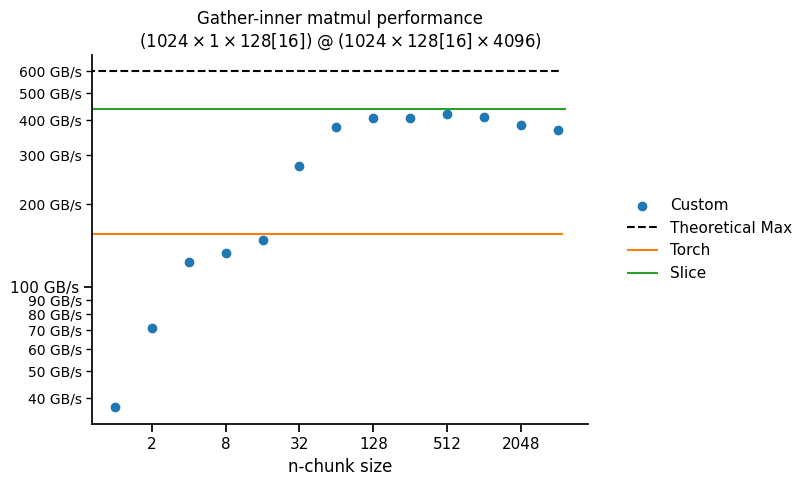

In [ ]:
g, k, n = 1024, 16, 4096
d = df.pipe(lambda d: d[(d.g == g) & (d.k == k) & (d.n == n)])
ax = plt.gca()
colors = iter(sns.color_palette())
ax.scatter(d.chunk, d.effective_bandwidth, color=next(colors), label="Custom")
ax.hlines(expected_memory_bandwidth, *ax.get_xlim(), "k", "--", label="Theoretical Max")
for method in ["torch", "slice"]:
    ax.hlines(d[d.method==method].effective_bandwidth, *ax.get_xlim(), next(colors), label=method.capitalize())
ax.set_xscale("log", base=2)
ax.set_yscale("log", base=10)
ax.xaxis.set_major_formatter("{x:.0f}")
ax.set_xlabel("n-chunk size")
ax.set_title(f"Gather-inner matmul performance\n$({g} \\times 1 \\times 128[{k}]) \;@\; ({g} \\times 128[{k}] \\times {n})$")
ax.legend(loc="center left", bbox_to_anchor=(1.05, 0.5), frameon=False)
ax.yaxis.set_major_formatter(lambda x, _: f"{x/1e9:.0f} GB/s")
ax.yaxis.set_minor_formatter(lambda x, _: f"{x/1e9:.0f} GB/s")
ax.tick_params(axis="y", which="minor", labelsize=10)
sns.despine(ax=ax)

# 2. Performance is mainly explained by bytes transferred, but `k` has some effect

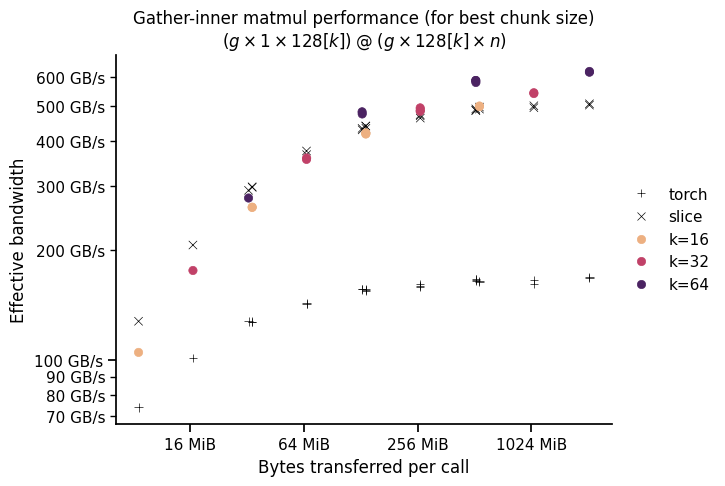

In [83]:
ax = sns.scatterplot(data=df[df.method!="custom"], y="effective_bandwidth", x="bytes_transferred", style="method",
                     color="k", edgecolor=None, markers=dict(torch="+", slice="x"))
sns.scatterplot(data=best, y="effective_bandwidth", x="bytes_transferred", hue="k", hue_norm=matplotlib.colors.LogNorm(),
                palette="flare", edgecolor=None)
ax.set_xscale("log", base=2)
ax.set_yscale("log")
ax.set_ylabel("Effective bandwidth")
ax.set_xlabel("Bytes transferred per call")
ax.set_title(f"Gather-inner matmul performance (for best chunk size)\n$(g \\times 1 \\times 128[k]) \;@\; (g \\times 128[k] \\times n)$")
ax.yaxis.set_major_formatter(lambda x, _: f"{x/1e9:.0f} GB/s")
ax.yaxis.set_minor_formatter(lambda x, _: f"{x/1e9:.0f} GB/s")
ax.yaxis.set_major_formatter(lambda x, _: f"{x/1e9:.0f} GB/s")
ax.xaxis.set_major_formatter(lambda x, _: f"{x/2**20:.0f} MiB")
handles, labels = ax.get_legend_handles_labels()
labels = [f"k={label}" if i >= 2 else label for i, label in enumerate(labels)]
ax.legend(handles, labels, frameon=False, bbox_to_anchor=(1, 0.5), loc="center left")
sns.despine(ax=ax)

# Dump some compiled kernels

In [112]:
k = 16
for chunk in [1, 16, 512]:
    kernel_cache, = G._kernel_gather_inner_bmv.cache.values()
    selected_cache, = (cache for key, cache in kernel_cache.items() if key[2] == (k, chunk, True))
    Path(f"../out/gather_matmul_benchmark/gather_inner_bmv_k={k}_chunk={chunk}.s").write_text(selected_cache.asm["ptx"])